In [80]:
import spotipy
import os 
import dotenv
import requests
import pandas as pdj
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
#Path local com os arquivos .json
base_path = "SpotifyPacks/spotify Extended Streaming History"

In [4]:
#Transformação dos arquivos JSON em DataFrames
dfs = []

files  = os.listdir(base_path)
#Percorrendo arquivos
for file in files:
    if file.startswith("Streaming_History_Audio") and file.endswith(".json"):
        file_path = os.path.join(base_path, file)
        
        df_temp = pd.read_json(file_path)
        dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

In [ ]:
display(df.count())
display(df.describe())
display(df.info())

ts                                   79091
platform                             79091
ms_played                            79091
conn_country                         79091
ip_addr                              79091
master_metadata_track_name           78686
master_metadata_album_artist_name    78686
master_metadata_album_album_name     78686
spotify_track_uri                    78686
episode_name                           404
episode_show_name                      404
spotify_episode_uri                    404
audiobook_title                          0
audiobook_uri                            0
audiobook_chapter_uri                    0
audiobook_chapter_title                  0
reason_start                         79091
reason_end                           79091
shuffle                              79091
skipped                              79091
offline                              79091
offline_timestamp                    70990
incognito_mode                       79091
minutes_pla

,ms_played,audiobook_title,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,offline_timestamp,minutes_played
count,7.909100e+04,0.0,0.0,0.0,0.0,7.099000e+04,79091.000000
mean,4.408411e+04,NaN,NaN,NaN,NaN,5.078522e+09,0.734735
std,7.248168e+04,NaN,NaN,NaN,NaN,7.426253e+10,1.208028
min,0.000000e+00,NaN,NaN,NaN,NaN,1.665789e+09,0.000000
25%,1.223000e+03,NaN,NaN,NaN,NaN,1.730523e+09,0.020383
50%,4.097000e+03,NaN,NaN,NaN,NaN,1.757096e+09,0.068283
75%,6.044300e+04,NaN,NaN,NaN,NaN,1.765042e+09,1.007383
max,1.432075e+06,NaN,NaN,NaN,NaN,1.665771e+12,23.867917


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79091 entries, 0 to 79090
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   ts                                 79091 non-null  datetime64[ns, UTC]
 1   platform                           79091 non-null  object             
 2   ms_played                          79091 non-null  int64              
 3   conn_country                       79091 non-null  object             
 4   ip_addr                            79091 non-null  object             
 5   master_metadata_track_name         78686 non-null  object             
 6   master_metadata_album_artist_name  78686 non-null  object             
 7   master_metadata_album_album_name   78686 non-null  object             
 8   spotify_track_uri                  78686 non-null  object             
 9   episode_name                       404 non-null   

None

In [24]:
#Convertendo milissegundos para minutos
df["minutes_played"] = df["ms_played"] / 60000

#Convertendo a coluna 'ts' para datetime
df['ts'] = pd.to_datetime(df['ts'], utc=True)

#Filtrando dados de 2023 em diante
df_2023 = df[(df['ts'] >= '2023-01-01')]

#Filtrando músicas puladas e com ms_played menor 
df_ms_played = df_2023[(df_2023['minutes_played'] >= 0.30) & (df_2023['skipped'] == False)]

In [25]:
#teste: qnt. de streams 79091 -> 7727
display(df_ms_played.count())
display(df_ms_played)

ts                                   10412
platform                             10412
ms_played                            10412
conn_country                         10412
ip_addr                              10412
master_metadata_track_name           10375
master_metadata_album_artist_name    10375
master_metadata_album_album_name     10375
spotify_track_uri                    10375
episode_name                            37
episode_show_name                       37
spotify_episode_uri                     37
audiobook_title                          0
audiobook_uri                            0
audiobook_chapter_uri                    0
audiobook_chapter_title                  0
reason_start                         10412
reason_end                           10412
shuffle                              10412
skipped                              10412
offline                              10412
offline_timestamp                    10412
incognito_mode                       10412
minutes_pla

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,minutes_played
10248,2023-01-02 13:35:47+00:00,android,175889,BR,201.0.94.20,Shut Down,BLACKPINK,BORN PINK,spotify:track:7gRFDGEzF9UkBV233yv2dc,None,...,NaN,NaN,clickrow,trackdone,True,False,False,1.672663e+09,False,2.931483
10250,2023-01-02 13:46:36+00:00,android,184444,BR,201.0.94.20,ANTIFRAGILE,LE SSERAFIM,ANTIFRAGILE,spotify:track:4fsQ0K37TOXa3hEQfjEic1,None,...,NaN,NaN,clickrow,trackdone,True,False,False,1.672663e+09,False,3.074067
10287,2023-01-02 14:12:21+00:00,android,162569,BR,201.0.94.20,Hard to Love,BLACKPINK,BORN PINK,spotify:track:3MJhPqL2IgGs7gHEB2M35q,None,...,NaN,NaN,fwdbtn,trackdone,True,False,False,1.672665e+09,False,2.709483
10292,2023-01-02 18:18:01+00:00,android,211631,BR,201.0.94.20,WHISTLE,BLACKPINK,SQUARE ONE,spotify:track:6NEoeBLQbOMw92qMeLfI40,None,...,NaN,NaN,clickrow,trackdone,True,False,False,1.672680e+09,False,3.527183
10313,2023-01-02 18:26:57+00:00,android,184444,BR,201.0.94.20,ANTIFRAGILE,LE SSERAFIM,ANTIFRAGILE,spotify:track:4fsQ0K37TOXa3hEQfjEic1,None,...,NaN,NaN,clickrow,trackdone,True,False,False,1.672680e+09,False,3.074067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79012,2025-12-17 19:45:48+00:00,android,208815,BR,2804:388:c3fb:e7fd:d466:bb5e:364d:90d,Born Again (feat. Doja Cat & RAYE),LISA,Born Again (feat. Doja Cat & RAYE),spotify:track:4CPuDVC8jhhK6lA2DIt8Cf,None,...,NaN,NaN,clickrow,unexpected-exit-while-paused,True,False,False,1.765990e+09,False,3.480250
79026,2025-12-17 20:00:46+00:00,android,221731,BR,177.189.106.128,"One Of The Girls (with JENNIE, Lily Rose Depp)",The Weeknd,The Idol Episode 4,spotify:track:7CyPwkp0oE8Ro9Dd5CUDjW,None,...,NaN,NaN,clickrow,logout,False,False,False,1.766001e+09,False,3.695517
79044,2025-12-17 20:29:02+00:00,android,70675,BR,2804:388:c3fb:e7fd:d466:bb5e:364d:90d,Debut,KATSEYE,Debut,spotify:track:58AZXyKRlsMBMcrRjpJpVG,None,...,NaN,NaN,clickrow,trackdone,True,False,False,1.766003e+09,False,1.177917
79049,2025-12-17 20:31:04+00:00,android,111079,BR,2804:388:c3fb:e7fd:d466:bb5e:364d:90d,ExtraL (feat. Doechii),JENNIE,Ruby,spotify:track:4EIFwndJvGpgFjsEbNuYif,None,...,NaN,NaN,clickrow,trackdone,True,False,False,1.766003e+09,False,1.851317


In [29]:
df_ms_played["year_month"] = df_ms_played['ts'].dt.to_period('M')

artists_listened = (
    df_ms_played
    .groupby(['year_month', 'master_metadata_album_artist_name'])
    .agg(
        count_played=('master_metadata_album_artist_name', 'size'),
        minutes_played=('minutes_played', 'sum') #Qual a a quantidade total de minutos de cada artistas
    )
    .reset_index()
)

display(artists_listened)

C:\Users\juliamattos-ieg\AppData\Local\Temp\ipykernel_36600\3648843599.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_ms_played["year_month"] = df_ms_played['ts'].dt.to_period('M')
C:\Users\juliamattos-ieg\AppData\Local\Temp\ipykernel_36600\3648843599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms_played["year_month"] = df_ms_played['ts'].dt.to_period('M')


,year_month,master_metadata_album_artist_name,count_played,minutes_played
0,2023-01,7 Minutoz,33,126.340050
1,2023-01,Ariana Grande,5,11.012767
2,2023-01,BLACKPINK,9,22.971567
3,2023-01,BTS,1,3.317550
4,2023-01,Bizarrap,1,1.869367
...,...,...,...,...
3206,2026-01,YoungBoy Never Broke Again,1,2.651433
3207,2026-01,ZICO,1,5.011583
3208,2026-01,Zion & Lennox,2,7.609317
3209,2026-01,bbno$,1,1.974450


In [30]:
#Ordenando os dados para que a estratégia de lags seja cumprida
artists_listened_ordered = artists_listened.sort_values(by=['master_metadata_album_artist_name', 'year_month'])
display(artists_listened_ordered)

#Exemplo de fucnionamento
# filtrar apenas as linhas do artista (G)I‑DLE
gidle = artists_listened_ordered[
    artists_listened_ordered['master_metadata_album_artist_name'] == '(G)I-DLE'
]
display(gidle)

,year_month,master_metadata_album_artist_name,count_played,minutes_played
1718,2025-05,$imba,1,2.087917
2197,2025-08,$imba,1,2.088183
609,2024-02,(G)I-DLE,3,5.374750
723,2024-05,(G)I-DLE,1,2.655333
758,2024-06,(G)I-DLE,4,10.401367
...,...,...,...,...
2141,2025-06,yellofish,1,2.285700
2451,2025-08,yellofish,1,2.285700
1480,2025-03,yeyts.,1,1.923000
326,2023-05,yoranda,1,2.796250


,year_month,master_metadata_album_artist_name,count_played,minutes_played
609,2024-02,(G)I-DLE,3,5.374750
723,2024-05,(G)I-DLE,1,2.655333
758,2024-06,(G)I-DLE,4,10.401367
786,2024-07,(G)I-DLE,2,5.374667
1136,2025-02,(G)I-DLE,2,5.374667


In [32]:
#Indica a quantidade de vezes que o artista foi ouvido no mês anterior, ou seja, o lag de 1 período -> como se estivessemos olhando para o mês passado, ou a última vez que o artista foi ouvido
artists_listened_ordered["1lag_count_played"] = artists_listened_ordered.groupby('master_metadata_album_artist_name')['count_played'].shift(1) #Como se fosse no primeiro, no segundo e no terceiro mês
artists_listened_ordered["2lag_count_played"] = artists_listened_ordered.groupby('master_metadata_album_artist_name')['count_played'].shift(2)
artists_listened_ordered["3lag_count_played"] = artists_listened_ordered.groupby('master_metadata_album_artist_name')['count_played'].shift(3)

#Criando 2 features para que o modelo acerte com mais precisão, a primeira é a tendência do artista crescer ou não, e a segunda é a média de vezes que o artista foi ouvido nos últimos 3 meses
#Basicamente, o modelo irá prever a tendência daquele determinado artista crescer ou não no número de streams
artists_listened_ordered["trend"] = artists_listened_ordered["1lag_count_played"] - artists_listened_ordered["2lag_count_played"] #Avalia a tendencia do artista se expandir ou não, se baseando nos 1lag_count_played e 2lag_count_played
display(artists_listened_ordered)

artists_listened_ordered['media'] = (
    artists_listened_ordered['1lag_count_played'] +
    artists_listened_ordered['2lag_count_played'] +
    artists_listened_ordered['3lag_count_played']
) / 3
display(artists_listened_ordered)

,year_month,master_metadata_album_artist_name,count_played,minutes_played,1lag_count_played,2lag_count_played,3lag_count_played,trend
0,2023-01,7 Minutoz,33,126.340050,NaN,NaN,NaN,NaN
16,2023-01,MHRAP,12,37.347883,NaN,NaN,NaN,NaN
2,2023-01,BLACKPINK,9,22.971567,NaN,NaN,NaN,NaN
25,2023-01,TWICE,7,18.420633,NaN,NaN,NaN,NaN
28,2023-01,aespa,7,19.058400,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3202,2026-01,Valesca Popozuda,1,2.743583,3.0,1.0,NaN,2.0
3204,2026-01,VoltRage,1,2.163333,NaN,NaN,NaN,NaN
3206,2026-01,YoungBoy Never Broke Again,1,2.651433,1.0,NaN,NaN,NaN
3207,2026-01,ZICO,1,5.011583,1.0,1.0,1.0,0.0


,year_month,master_metadata_album_artist_name,count_played,minutes_played,1lag_count_played,2lag_count_played,3lag_count_played,trend,media
0,2023-01,7 Minutoz,33,126.340050,NaN,NaN,NaN,NaN,NaN
16,2023-01,MHRAP,12,37.347883,NaN,NaN,NaN,NaN,NaN
2,2023-01,BLACKPINK,9,22.971567,NaN,NaN,NaN,NaN,NaN
25,2023-01,TWICE,7,18.420633,NaN,NaN,NaN,NaN,NaN
28,2023-01,aespa,7,19.058400,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3202,2026-01,Valesca Popozuda,1,2.743583,3.0,1.0,NaN,2.0,NaN
3204,2026-01,VoltRage,1,2.163333,NaN,NaN,NaN,NaN,NaN
3206,2026-01,YoungBoy Never Broke Again,1,2.651433,1.0,NaN,NaN,NaN,NaN
3207,2026-01,ZICO,1,5.011583,1.0,1.0,1.0,0.0,1.0


In [ ]:
artists_listened_ordered = artists_listened_ordered.sort_values(by=['year_month', 'count_played'], ascending=[True, False])
# display(artists_listened_ordered)
top_artist = artists_listened_ordered.groupby('year_month').first().reset_index()
top_artist["rank"] = 1
top_artist.fillna(0, inplace=True)
# display(top_artist)

df_artists = pd.merge(top_artist, artists_listened_ordered,how='left', on='master_metadata_album_artist_name')
artists_listened = artists_listened_ordered.merge(
    top_artist[['year_month','master_metadata_album_artist_name','rank']],
    on=['year_month','master_metadata_album_artist_name'],
    how='left'
)
artists_listened["rank"] = artists_listened['rank'].fillna(0)
artists_listened_final = artists_listened.dropna(subset=['1lag_count_played'])
display(artists_listened_final)

final_features = [
    '1lag_count_played','2lag_count_played' ,'3lag_count_played',
    'minutes_played','trend','media'
]

,year_month,master_metadata_album_artist_name,count_played,minutes_played,1lag_count_played,2lag_count_played,3lag_count_played,trend,media,rank
29,2023-02,Dua Lipa,14,40.854250,5.0,NaN,NaN,NaN,NaN,1.0
31,2023-02,BLACKPINK,11,31.322233,9.0,NaN,NaN,NaN,NaN,0.0
33,2023-02,NewJeans,7,21.852883,1.0,NaN,NaN,NaN,NaN,0.0
34,2023-02,Ariana Grande,6,17.510367,5.0,NaN,NaN,NaN,NaN,0.0
35,2023-02,TWICE,6,13.548400,7.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
3203,2026-01,Thiaguinho,1,0.415450,4.0,NaN,NaN,NaN,NaN,0.0
3205,2026-01,Travis Scott,1,3.175950,5.0,2.0,17.0,3.0,8.0,0.0
3206,2026-01,Valesca Popozuda,1,2.743583,3.0,1.0,NaN,2.0,NaN,0.0
3208,2026-01,YoungBoy Never Broke Again,1,2.651433,1.0,NaN,NaN,NaN,NaN,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

In [145]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42
)

model.fit(X, y)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

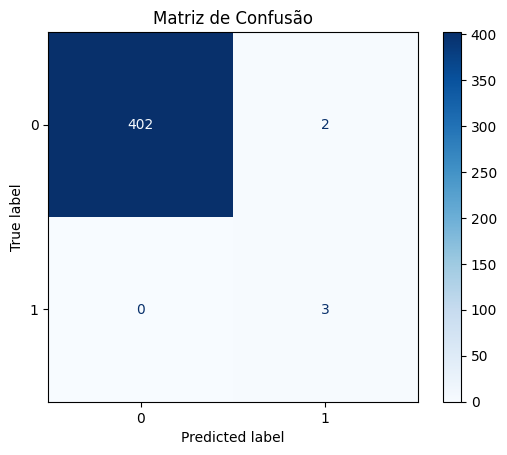

In [146]:
probs_test = model.predict_proba(X_test)[:,1]

# aplicar threshold
threshold = 0.2
y_pred = (probs_test >= threshold).astype(int)

# matriz
cm = confusion_matrix(y_test, y_pred)

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusão")
plt.show()

In [147]:
probs_test = model.predict_proba(X_test)[:,1]
threshold = 0.2
y_pred = (probs_test >= threshold).astype(int)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.995085995085995


In [148]:
final_features = X_train.columns.tolist()

ultimo_mes = artists_listened_final.sort_values('year_month').groupby(
    'master_metadata_album_artist_name'
).last().reset_index()

y_pred = ultimo_mes[final_features]

ultimo_mes['prob_top1'] = model.predict_proba(y_pred)[:, 1]

In [153]:
top_previsto = ultimo_mes.sort_values('prob_top1', ascending=False).head(5)

display(top_previsto)

,master_metadata_album_artist_name,year_month,count_played,minutes_played,1lag_count_played,2lag_count_played,3lag_count_played,trend,media,rank,prob_top1
199,KATSEYE,2026-01,49,74.300683,59.0,47.0,66.0,12.0,57.333333,1.0,0.664919
397,Towerz,2025-08,22,57.583883,2.0,0.0,0.0,0.0,0.000000,0.0,0.146713
51,Britney Spears,2026-01,24,78.184500,1.0,2.0,2.0,-1.0,1.666667,0.0,0.144621
421,YEONJUN,2026-01,15,34.639000,8.0,1.0,0.0,7.0,0.000000,0.0,0.116172
256,Madison Beer,2026-01,30,83.162383,10.0,2.0,9.0,8.0,7.000000,0.0,0.092637


In [155]:
#Erro:
# Found input variables with inconsistent numbers of samples: [407, 504]

#Conserto:
probs_test = model.predict_proba(X_test)[:,1]

threshold = 0.2
y_pred = (probs_test >= threshold).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       404
         1.0       0.60      1.00      0.75         3

    accuracy                           1.00       407
   macro avg       0.80      1.00      0.87       407
weighted avg       1.00      1.00      1.00       407



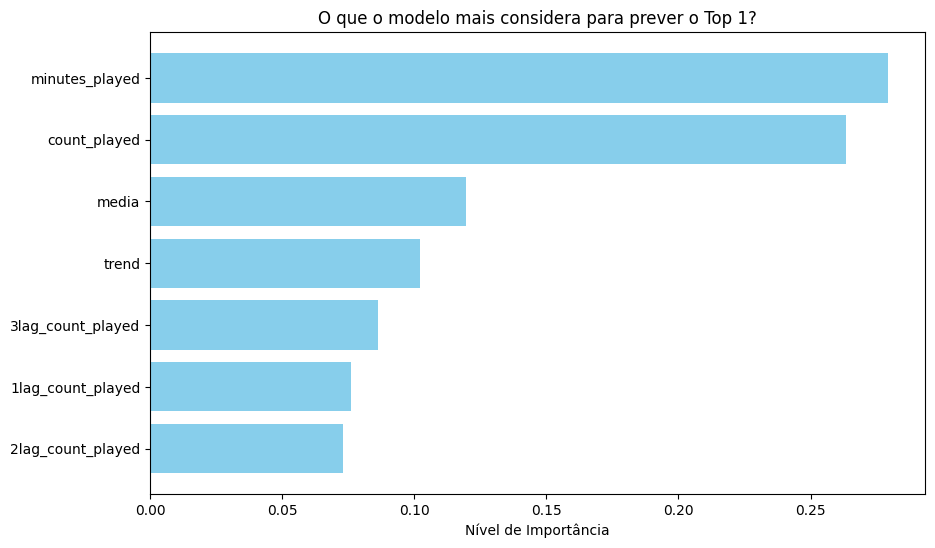

In [150]:
importancias = model.feature_importances_
features = X.columns 

df_importancia = pd.DataFrame({'Feature': features, 'Importancia': importancias})
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(df_importancia['Feature'], df_importancia['Importancia'], color='skyblue')
plt.xlabel('Nível de Importância')
plt.title('O que o modelo mais considera para prever o Top 1?')
plt.gca().invert_yaxis() 
plt.show()